In [1]:
import csv, os, glob
import numpy as np
import tensorflow as tf
import features as features_lib

In [2]:
import tensorflow as tf
import yamnet_short
yamnet_short = yamnet_short.Yamnet_short()
yamnet_model = yamnet_short.model()
yamnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
yamnet_model.summary()


Model: "yamnet_frames"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 64, 1)]       0         
                                                                 
 layer1/conv (Conv2D)        (None, 48, 32, 32)        288       
                                                                 
 layer1/conv/bn (BatchNormal  (None, 48, 32, 32)       96        
 ization)                                                        
                                                                 
 layer1/relu (ReLU)          (None, 48, 32, 32)        0         
                                                                 
 layer2/depthwise_conv (Dept  (None, 48, 32, 32)       288       
 hwiseConv2D)                                                    
                                                                 
 layer2/depthwise_conv/bn (B  (None, 48, 32, 32)     

In [3]:
parent_dir = "D:\\datasets\\UrbanSounds8K\\resampled_wav_16000"
folds = sub_dirs = np.array(['fold1','fold2','fold3','fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'])
classes = ['0_air_conditioner', '1_car_horn', '2_children_playing', '3_dog_bark', 
'4_drilling', '5_engine_idling', '6_gun_shot', '7_jackhammer', '8_siren', '9_street_music']

filenames_all = []
for fold in folds:
    filenames = glob.glob(os.path.join(parent_dir, fold, "*.wav"))
    filenames_all.extend(filenames)

In [4]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
    # AddBackgroundNoise
    # AddShortNoises
])

@tf.function
def augment_sample(augment, wave):
    return augment(samples=wave, sample_rate=16000)    


In [7]:
import params as yamnet_params
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)
  
def get_label(filename):
    label = tf.strings.split(filename, "\\")[-1]
    label = tf.strings.split(label, "-")[1]
    length = len(get_embedding(filename))
    try: 
      label = tf.repeat(label, length)
    except:
      pass
    label = tf.cast(int(label), dtype='int32')
    return label

def get_waveform_no_label(file_path):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  waveform = tf.cast(waveform, dtype=tf.float32)
  return waveform

@tf.function
def get_embedding(filename, AUGMENT=False):
  params = yamnet_params.Params(sample_rate=16000, patch_hop_seconds=0.5)
  waveform = get_waveform_no_label(filename)
  if AUGMENT==True:
    waveform = augment_sample(augment, waveform)
  waveform_padded = features_lib.pad_waveform(waveform, params)
  log_mel_spectrogram, features = features_lib.waveform_to_log_mel_spectrogram_patches(
      waveform_padded, params)
  return tf.expand_dims(features, axis=-1)
  # return log_mel_spectrogram

# Create a dataset of filenames
dataset = tf.data.Dataset.from_tensor_slices(filenames_all)

# Map the filenames to the embeddings
dataset_samples_noaugment = dataset.map(
  map_func = lambda x: tf.py_function(get_embedding, inp=[x, False], Tout=tf.float32, name=None),
  num_parallel_calls=tf.data.AUTOTUNE
)
dataset_samples_augment = dataset.map(
  map_func = lambda x: tf.py_function(get_embedding, inp=[x, True], Tout=tf.float32, name=None),
  num_parallel_calls=tf.data.AUTOTUNE
)

dataset_samples_combined = dataset_samples_noaugment.concatenate(dataset_samples_augment)

dataset_labels = dataset.map(get_label)
dataset_labels_combined = dataset_labels.concatenate(dataset_labels)


# Flatmap the embeddings to squeeze dim=0 and then zip the samples and labels
dataset_samples_combined = dataset_samples_combined.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))
dataset_labels_combined = dataset_labels_combined.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))

dataset = dataset.zip((dataset_samples_combined, dataset_labels_combined))

# Train-test split
length = len(list(dataset))
print("length of dataset", length)
AUTOTUNE = tf.data.AUTOTUNE

# https://stackoverflow.com/questions/64684139/tensorflow-keras-model-fit-can-not-read-validation-data-in-dataset-format
## Take roughly first 10% (first fold, unaugmented) of data as validation; batch too early cannot validate
dataset_test = dataset.take(int(length*0.1))
dataset_train = dataset.skip(int(length*0.1))

dataset_test = dataset_test.shuffle(64).batch(64).cache().prefetch(AUTOTUNE)
dataset_train = dataset_train.shuffle(64).batch(64).cache().prefetch(AUTOTUNE)


length of dataset 125060


In [8]:
# Declare checkpoint path and start training
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

yamnet_model.fit(dataset_train, validation_data = dataset_test, epochs=30, verbose=1, callbacks=[cp_callback])

# Save HD5 model in the end 
yamnet_model.save('./checkpoints/whole_model.hd5')
# new_model = tf.keras.models.load_model('my_model.h5')

Epoch 1/30
     50/Unknown - 16s 63ms/step - loss: 2.4198 - accuracy: 0.1553

KeyboardInterrupt: 

In [ ]:
# Create a dataset of filenames
dataset_final = tf.data.Dataset.from_tensor_slices(filenames_all[:int(len(filenames_all)*0.05)])

# Map the filenames to the embeddings
dataset_final_samples = dataset_final.map(
  map_func = lambda x: tf.py_function(get_embedding, inp=[x, False], Tout=tf.float32, name=None),
  num_parallel_calls=tf.data.AUTOTUNE
)

def get_first_element(x):
  return x[0]

dataset_final_labels = dataset_final.map(get_label)
dataset_final_labels = dataset_final_labels.map(
  lambda x: get_first_element(x)
)


In [ ]:
y_preds = []
for x in dataset_final_samples:
    y_pred = tf.argmax(tf.math.reduce_sum(yamnet_model.predict(x), axis=0))
    y_preds.append(y_pred)
y_preds = np.array(y_preds)

def get_numpy(a_list):
    for b in a_list:
        yield b.numpy()

y_true = np.array([b for b in get_numpy(list(dataset_final_labels))])

0.9243119266055045


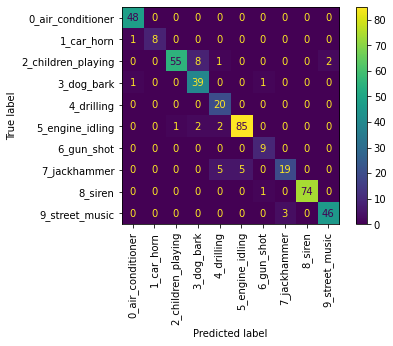

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(accuracy_score(y_true, y_preds))

cm = confusion_matrix(y_true, y_preds, labels=range(len(classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot(xticks_rotation="vertical")